In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import gzip
import pickle
import datetime

from collections import defaultdict
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score, precision_score, recall_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
#resfile = open('../results/yeast_records.txt', 'r')
#result = json.load(resfile)['records']
#resfile.close()

In [3]:
#json_file = gzip.open('../results/yeast_records.json.gz', 'wb')
#for res in result:
#    json_str = ('%s\n' % json.dumps(res)).encode('utf-8')
#    json_file.write(json_str)
#json_file.close()

In [4]:
dataset_list = ['yeast', 'woman'] #, 'diabete']
blackbox_list = ['rf', 'svm', 'mlp']

In [5]:
mixed_fidelity_sn = defaultdict(list)
mixed_fidelity_rn = defaultdict(list)
union_fidelity_sn = defaultdict(list)
union_fidelity_rn = defaultdict(list)

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output_ric/%s_%s_records.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']

            mixed_fidelity_sn[bb_name].append(r['fidelity_tree1_syn'])
            mixed_fidelity_rn[bb_name].append(r['fidelity_tree1_kNN'])

            union_fidelity_sn[bb_name].append(r['fidelity_tree2_syn'])
            union_fidelity_rn[bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-10-30 15:12:04.590820 dataset: yeast
2018-10-30 15:12:04.591081 blackbox: rf
2018-10-30 15:12:04.605163 blackbox: svm
2018-10-30 15:12:04.613357 blackbox: mlp
2018-10-30 15:12:04.622721 dataset: woman
2018-10-30 15:12:04.622853 blackbox: rf
2018-10-30 15:12:04.625203 blackbox: svm
2018-10-30 15:12:04.627427 blackbox: mlp


In [6]:
print('Table 2')
for bb_name in blackbox_list:
    print(bb_name)
    print('\tmixed fidelity sn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_sn[bb_name]), np.std(mixed_fidelity_sn[bb_name])))
    print('\tunion fidelity sn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_sn[bb_name]), np.std(union_fidelity_sn[bb_name])))
    print('---')
    print('\tmixed fidelity rn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_rn[bb_name]), np.std(mixed_fidelity_rn[bb_name])))
    print('\tunion fidelity rn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_rn[bb_name]), np.std(union_fidelity_rn[bb_name])))

Table 2
rf
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.704 \pm 0.102
---
	mixed fidelity rn: 0.705 \pm 0.123
	union fidelity rn: 0.720 \pm 0.132
svm
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.788 \pm 0.100
---
	mixed fidelity rn: 0.740 \pm 0.164
	union fidelity rn: 0.750 \pm 0.204
mlp
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.750 \pm 0.151
---
	mixed fidelity rn: 0.700 \pm 0.155
	union fidelity rn: 0.733 \pm 0.166


In [7]:
print('Plot var alpha')
#TODO

Plot var alpha


In [8]:
mixed_fidelity_sn = defaultdict(lambda: defaultdict(list))
mixed_fidelity_rn = defaultdict(lambda: defaultdict(list))
mixed_hit = defaultdict(lambda: defaultdict(list))


resfile = gzip.open('../output/yeast_alphabeta.json.gz', 'rb')
for row in resfile:
    r = json.loads(row.decode('utf-8').strip())
    bb_name = r['bb_name']
    dataset_name = r['dataset_name']
    alpha = float(r['alpha'])
    mixed_fidelity_sn[bb_name][alpha].append(float(r['fidelity_tree1_syn']))
    mixed_fidelity_rn[bb_name][alpha].append(float(r['fidelity_tree1_kNN']))
    mixed_hit[bb_name][alpha].append(1.0 - float(r['hit_sm_tree1']))
resfile.close()

In [9]:
bb_name_map = {
    'rf': 'RF',
    'svm': 'SVM',
    'mlp': 'MLP'
}

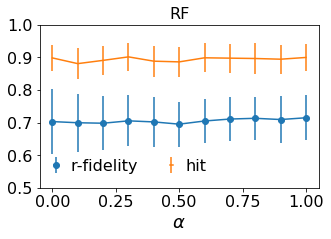

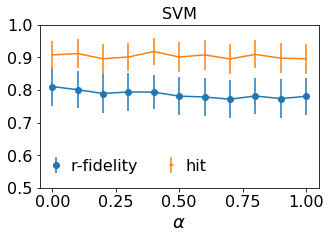

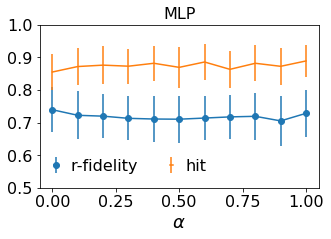

In [10]:
alphas = [np.round(x, 2) for x in np.arange(0.0, 1.1, 0.1)]

for bb_name in blackbox_list:
    fs_means = list()
    fs_std = list()
    fr_means = list()
    fr_std = list()
    hit_means = list()
    hit_std = list()
    for alpha in alphas:
        fs_means.append(np.mean(mixed_fidelity_sn[bb_name][alpha]))
        fs_std.append(np.std(mixed_fidelity_sn[bb_name][alpha]))
        fr_means.append(np.mean(mixed_fidelity_rn[bb_name][alpha]))
        fr_std.append(np.std(mixed_fidelity_rn[bb_name][alpha]))
        hit_means.append(np.mean(mixed_hit[bb_name][alpha]))
        hit_std.append(np.std(mixed_hit[bb_name][alpha]))
    
    plt.figure(figsize=(5,3))
    plt.errorbar(alphas, fr_means, yerr=np.array(fr_std)/2, marker='o', label='r-fidelity')
    plt.errorbar(alphas, hit_means, yerr=np.array(hit_std)/2, marker='', label='hit')
    plt.ylim([0.5, 1.0])
    plt.title(bb_name_map[bb_name], fontsize=16)
    plt.xlabel(r'$\alpha$', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(loc='lower left', fontsize=16, ncol=2, labelspacing=0, handlelength=0.2, frameon=False)
    plt.savefig('../fig/alpha_%s.png' % bb_name, format='png', bbox_inches='tight')
    plt.show()

In [11]:
hit = defaultdict(lambda: defaultdict(list))
for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output_ric/%s_%s_records.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']

            hit[dataset_name][bb_name].append(1.0 - r['hit_sm_tree1'])

        resfile.close()

2018-10-30 15:12:17.985674 dataset: yeast
2018-10-30 15:12:17.985995 blackbox: rf
2018-10-30 15:12:18.002944 blackbox: svm
2018-10-30 15:12:18.016388 blackbox: mlp
2018-10-30 15:12:18.027574 dataset: woman
2018-10-30 15:12:18.027738 blackbox: rf
2018-10-30 15:12:18.030441 blackbox: svm
2018-10-30 15:12:18.032918 blackbox: mlp


In [12]:
hit_gdt = defaultdict(lambda: defaultdict(list))
for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/%s_%s_labels.json.gz' % (bb_name, dataset), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_label = r['bb_label']
            gdt_label = r['gdt_label']

            hit_gdt[dataset][bb_name].append(1.0 - hamming(bb_label, gdt_label))
        resfile.close()

2018-10-30 15:12:18.688308 dataset: yeast
2018-10-30 15:12:18.688546 blackbox: rf
2018-10-30 15:12:18.731619 blackbox: svm
2018-10-30 15:12:18.767692 blackbox: mlp
2018-10-30 15:12:18.795333 dataset: woman
2018-10-30 15:12:18.795434 blackbox: rf
2018-10-30 15:12:18.952957 blackbox: svm
2018-10-30 15:12:19.119590 blackbox: mlp


Table 3 e plot
yeast
	 rf
		hit MARLENA 0.905 pm 0.081
		hit GDT 0.947 pm 0.066
	 svm
		hit MARLENA 0.901 pm 0.094
		hit GDT 0.939 pm 0.068
	 mlp
		hit MARLENA 0.880 pm 0.108
		hit GDT 0.970 pm 0.052
woman
	 rf
		hit MARLENA 0.857 pm 0.112
		hit GDT 0.981 pm 0.041
	 svm
		hit MARLENA 0.777 pm 0.132
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.786 pm 0.117
		hit GDT 0.979 pm 0.048


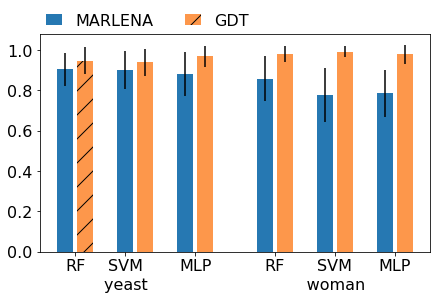

In [13]:
print('Table 3 e plot')

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit[dataset_name][bb_name]), np.std(hit[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit[dataset_name][bb_name]), 
                    yerr=np.std(hit[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit[dataset_name][bb_name]), 
                    yerr=np.std(hit[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/barplot.png', format='png', bbox_inches='tight')
plt.show()

In [108]:
bb_labels = defaultdict(lambda: defaultdict(list))
marlena_labels = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output_ric/%s_%s_records.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            bb_labels[dataset_name][bb_name].append(r['i2e_bb_label'])
            marlena_labels[dataset_name][bb_name].append(r['i2e_tree1_label'])  
        resfile.close()

2018-10-30 15:08:26.882339 dataset: yeast
2018-10-30 15:08:26.882494 blackbox: rf
2018-10-30 15:08:26.890998 blackbox: svm
2018-10-30 15:08:26.896030 blackbox: mlp
2018-10-30 15:08:26.900621 dataset: woman
2018-10-30 15:08:26.900743 blackbox: rf
2018-10-30 15:08:26.902874 blackbox: svm
2018-10-30 15:08:26.904463 blackbox: mlp


In [109]:
gdt_labels = defaultdict(lambda: defaultdict(list))
for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/%s_%s_labels.json.gz' % (bb_name, dataset), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            gdt_label = r['gdt_label']

            gdt_labels[dataset][bb_name].append(r['gdt_label'])
        resfile.close() 

2018-10-30 15:08:27.663882 dataset: yeast
2018-10-30 15:08:27.664219 blackbox: rf
2018-10-30 15:08:27.674366 blackbox: svm
2018-10-30 15:08:27.682674 blackbox: mlp
2018-10-30 15:08:27.690303 dataset: woman
2018-10-30 15:08:27.690444 blackbox: rf
2018-10-30 15:08:27.740086 blackbox: svm
2018-10-30 15:08:27.782035 blackbox: mlp


In [112]:
print('Table 4')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4
yeast
	 rf
MARLENA: avg 0.463, std 0.376, median 0.621
GDT:	 avg 0.604, std 0.384, median 0.759
	 svm
MARLENA: avg 0.595, std 0.299, median 0.632
GDT:	 avg 0.699, std 0.279, median 0.800
	 mlp
MARLENA: avg 0.538, std 0.311, median 0.667
GDT:	 avg 0.929, std 0.060, median 0.939

woman
	 rf
MARLENA: avg 0.143, std 0.247, median 0.000
GDT:	 avg 0.500, std 0.500, median 0.500
	 svm
MARLENA: avg 0.071, std 0.124, median 0.000
GDT:	 avg 1.000, std 0.000, median 1.000
	 mlp
MARLENA: avg 0.324, std 0.239, median 0.400
GDT:	 avg 1.000, std 0.000, median 1.000

